In [154]:
## Data Generation
import pandas as pd
import numpy as np
import datetime
import csv

In [155]:
Stresses={
        'T_1':80,
        #'T_2':80,
       # 'T_3':80,
       # 'T_4':80,
        #'T_5':80,
       # 'T_6':80
}
columns=['stresses','magnetostriction','strain']

In [156]:
data=pd.DataFrame(columns=columns)
n_e=1000

In [157]:
for i in range(n_e):
        stress=np.random.normal(80,20)
        magnetostriction=np.random.normal(0.006,0.0001)
        strain=np.random.normal(0.004,0.0001)
        data.loc[i]=[stress,magnetostriction,strain]


In [223]:
##for test data
for i in range(400):
        stress=np.random.normal(80,20)
        magnetostriction=np.random.normal(0.006,0.0001)
        strain=np.random.normal(0.004,0.0001)
        data.loc[i]=[stress,magnetostriction,strain]

dataframe_test=pd.read_csv('test_data',index_col=False)
dataframe_test.head()
dataframe=pd.read_csv('test_data',index_col=False)
X_test=dataframe_test[['stresses','magnetostriction','strain']]
Y_test=dataframe_test[['stresses']]
x_test=X_test.to_numpy()
y_test=Y_test.to_numpy()

In [158]:
dataframe=pd.read_csv('test_data',index_col=False)

In [159]:
dataframe.head()

,Unnamed: 0,stresses,magnetostriction,strain
0,0,44.030513,0.006046,0.003848
1,1,70.611077,0.005925,0.003927
2,2,62.404324,0.005907,0.003907
3,3,81.506225,0.005928,0.003896
4,4,78.625517,0.005878,0.003937


In [176]:
X_input=dataframe[['stresses','magnetostriction','strain']]
#y_input=dataframe['stresses']
from sklearn.model_selection import train_test_split


In [177]:
X=X_input
#y=y_input

In [178]:
#X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
X

,stresses,magnetostriction,strain
0,44.030513,0.006046,0.003848
1,70.611077,0.005925,0.003927
2,62.404324,0.005907,0.003907
3,81.506225,0.005928,0.003896
4,78.625517,0.005878,0.003937
...,...,...,...
995,79.714180,0.006043,0.003964
996,85.637667,0.005986,0.003805
997,58.269149,0.005901,0.003992
998,57.640931,0.006058,0.003996


In [179]:
#x_train = X_train.astype('float32')
#x_test = X_test.astype('float32')
#y_train=y_train.astype('float')
#y_test=y_test.astype('float')


In [180]:
array_input_x=X.to_numpy()###700X2
#array_input_y=y_train.to_numpy()###700X1

In [181]:
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
#from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [182]:
# BUILD THE MODEL

# # ================= #############
# # Encoder
# # ================= ############

latent_dim = 2 # Number of latent dim parameters

input_encoder = Input(shape=3, name='encoder_input')
x = Dense(32, activation='relu')(input_encoder)
x = Dense(64 , activation='relu')(x)


conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
#Flatten


In [183]:
conv_shape

(None, 64)

In [184]:

# Two outputs, for latent mean and log variance (std. dev.)
#Use these to sample random variables in latent space to which inputs are mapped. 
z_mu = Dense(latent_dim, name='latent_mu')(x)   #Mean values of encoded input
z_sigma = Dense(latent_dim, name='latent_sigma')(x)  #Std dev. (variance) of encoded input

In [185]:
#REPARAMETERIZATION TRICK
# Define sampling function to sample from the distribution
# Reparameterize sample based on the process defined by Gunderson and Huang
# into the shape of: mu + sigma squared x eps
#This is to allow gradient descent to allow for gradient estimation accurately. 
def sample_z(args):
  z_mu, z_sigma = args
  eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
  return z_mu + K.exp(z_sigma / 2) * eps

In [186]:
# sample vector from the latent distribution
# z is the labda custom layer we are adding for gradient descent calculations
  # using mu and variance (sigma)
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

In [187]:
#Z (lambda layer) will be the last layer in the encoder.
# Define and summarize encoder model.
encoder = Model(input_encoder, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 3)]          0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 32)           128         ['encoder_input[0][0]']          
                                                                                                  
 dense_16 (Dense)               (None, 64)           2112        ['dense_15[0][0]']               
                                                                                                  
 latent_mu (Dense)              (None, 2)            130         ['dense_16[0][0]']               
                                                                                            

In [213]:
# Decoder

# decoder takes the latent vector as input
decoder_input = Input(shape=(latent_dim, ), name='decoder_input')

#we want our final utput to be same shape original input.
x = Dense(3, activation='relu')(decoder_input)

# Define and summarize decoder model
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

# apply the decoder to the latent sample 
z_decoded = decoder(z)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_22 (Dense)            (None, 3)                 9         
                                                                 
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


In [214]:
#Define custom loss
#VAE is trained using two loss functions reconstruction loss and KL divergence
#Let us add a class to define a custom layer with loss
class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.mse(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

In [215]:
# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_encoder, z_decoded])
# y is basically the original image after encoding input img to mu, sigma, z
# and decoding sampled z values.
#This will be used as output for vae

# =================
# VAE 
# =================
vae = Model(input_encoder, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 3)]          0           []                               
                                                                                                  
 dense_15 (Dense)               (None, 32)           128         ['encoder_input[0][0]']          
                                                                                                  
 dense_16 (Dense)               (None, 64)           2112        ['dense_15[0][0]']               
                                                                                                  
 latent_mu (Dense)              (None, 2)            130         ['dense_16[0][0]']               
                                                                                                

In [216]:
z_decoded.shape

TensorShape([None, 3])

In [219]:
# Train autoencoder
vae.fit(array_input_x, None, epochs = 100, batch_size = 32, validation_split = 0.2)

Train on 800 samples, validate on 200 samples
Epoch 1/100
800/800 [==============================] - 0s 71us/sample - loss: 3.1782 - val_loss: 3.3517
Epoch 2/100
800/800 [==============================] - 0s 74us/sample - loss: 3.1509 - val_loss: 3.3235
Epoch 3/100
800/800 [==============================] - 0s 80us/sample - loss: 3.1245 - val_loss: 3.2961
Epoch 4/100
800/800 [==============================] - 0s 86us/sample - loss: 3.0984 - val_loss: 3.2685
Epoch 5/100
800/800 [==============================] - 0s 77us/sample - loss: 3.0728 - val_loss: 3.2415
Epoch 6/100
800/800 [==============================] - 0s 87us/sample - loss: 3.0472 - val_loss: 3.2150
Epoch 7/100
800/800 [==============================] - 0s 80us/sample - loss: 3.0226 - val_loss: 3.1895
Epoch 8/100
800/800 [==============================] - 0s 76us/sample - loss: 2.9985 - val_loss: 3.1640
Epoch 9/100
800/800 [==============================] - 0s 70us/sample - loss: 2.9746 - val_loss: 3.1389
Epoch 10/100
800/8

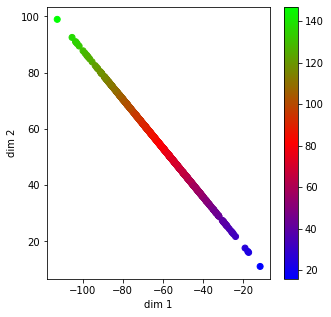

In [230]:
# =================
# Visualize results
# =================
#Visualize inputs mapped to the Latent space
#Remember that we have encoded inputs to latent space dimension = 2. 
#Extract z_mu --> first parameter in the result of encoder prediction representing mean

mu, _, _ = encoder.predict(x_test)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(5, 5))
plt.scatter(mu[:, 0], mu[:, 1], c=y_test, cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

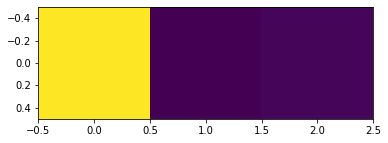

In [232]:
sample_vector = np.array([[-100,100]])
decoded_example = decoder.predict(sample_vector)
#decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
plt.imshow(decoded_example)

